# creating a 3d projection with `UMAP`

In [1]:
import os
import itertools

import cudf
from cuml.manifold.umap import UMAP

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [2]:
# import colour mappings
colour_mappings_folder = "./embedding_colour_mappings"
colour_mappings = {}

colour_mappings["collection_category"] = pd.read_csv(
    f"{colour_mappings_folder}/mapping_collection_category.tsv",    
    sep="\t",
    index_col=0,
    header=None,
    names=["value", "group"],
)

colour_mappings["database"] = pd.read_csv(
    f"{colour_mappings_folder}/mapping_database.tsv",    
    sep="\t",
    index_col=0,
    header=None,
    names=["value", "group"],
)

colour_mappings["type"] = pd.read_csv(
    f"{colour_mappings_folder}/mapping_type.tsv",    
    sep="\t",
    index_col=0,
    header=None,
    names=["value", "group"],
)


In [3]:
# load embeddings matrix
embeddings_path = "../data/processed/final_model_dglke/heritageconnector_RotatE_entity.npy"
ent_embeddings = np.load(embeddings_path).astype('float32')
ent_embeddings.shape

(645565, 800)

## Set up parameter tuning

In [69]:
def plot(projection: np.ndarray, colour_map: str, title: str, save_path: str = None, max_legend_items=20):
    def get_cmap_string(palette, domain):
        domain_unique = np.unique(domain)
        hash_table = {key: i_str for i_str, key in enumerate(domain_unique)}
        mpl_cmap = mpl.cm.get_cmap(palette, lut=len(domain_unique))

        def cmap_out(X, **kwargs):
            return mpl_cmap(hash_table[X], **kwargs)

        return cmap_out


    projection_df = pd.DataFrame(projection, columns=("x", "y", "z"))
    projection_df["group"] = colour_mappings[colour_map]["group"]

    if colour_map == "collection_category":
        projection_df = projection_df[projection_df['group'].fillna("").str.startswith("Category")]
        n_most_freq_categories = colour_mappings[colour_map]["group"].value_counts()[0:max_legend_items+4].index.tolist()
        projection_df = projection_df[projection_df["group"].isin(n_most_freq_categories)]

    projection_df = projection_df[~projection_df["group"].isna()]
    cmap = get_cmap_string(palette='viridis', domain=projection_df['group'].unique())

    colours = [cmap(i) for i in projection_df.loc[:, "group"]]

    fig = plt.figure(figsize=(20,20))

    ax = Axes3D(fig) # Method 1
    # ax = fig.add_subplot(111, projection='3d') # Method 2

    sc = ax.scatter(
            projection_df.loc[:, "x"], 
            projection_df.loc[:, "y"], 
            projection_df.loc[:, "z"], 
            c=colours, 
            s=0.5
        )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    lim = [-30, 30]

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.set_zlim(*lim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.legend(*sc.legend_elements(), loc="upper right")
    ax.set_title(title)
    
    plt.show()
    
    if save_path:
        plt.savefig(save_path)
    
    
def run_iteration(umap_params, run_idx):
    print(f"Run {run_idx}. Params {umap_params}")
    projection = UMAP(    
        **umap_params,
        n_epochs=1000,
        n_components=3
    ).fit_transform(ent_embeddings)
    
    for cmap in colour_mappings.keys():
        plot(projection, cmap, title=f"Run {run_idx}: {umap_params}. {cmap}", save_path=os.path.join(save_folder, f"run_{run_idx}_{cmap}.png"))
        
    return projection

def get_random_samples(params, n, replacement=False, seed=42):
    all_keys = params.keys()
    all_vals = [v for k,v in params.items()]
    combinations = list(itertools.product(*all_vals))
    
    rnd = np.random.RandomState(seed)
    res_list = [combinations[i] for i in rnd.choice(len(combinations), n, replace=replacement)]
    all_res = []
    
    for p in res_list:
        all_res.append( {k: p[i] for (i,k) in enumerate(all_keys)} )
        
    return all_res

In [67]:
params = {
    "n_neighbors": [50, 100, 150],
    "negative_sample_rate": [5, 10, 20, 40]
}

param_list = get_random_samples(params, 5)

param_list

[{'n_neighbors': 150, 'negative_sample_rate': 20},
 {'n_neighbors': 150, 'negative_sample_rate': 10},
 {'n_neighbors': 50, 'negative_sample_rate': 5},
 {'n_neighbors': 150, 'negative_sample_rate': 5},
 {'n_neighbors': 100, 'negative_sample_rate': 10}]

## Run parameter tuning

0it [00:00, ?it/s]

Run 1. Params {'n_neighbors': 150, 'negative_sample_rate': 20}


<ipython-input-69-75ea28b5e002>:28: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) # Method 1


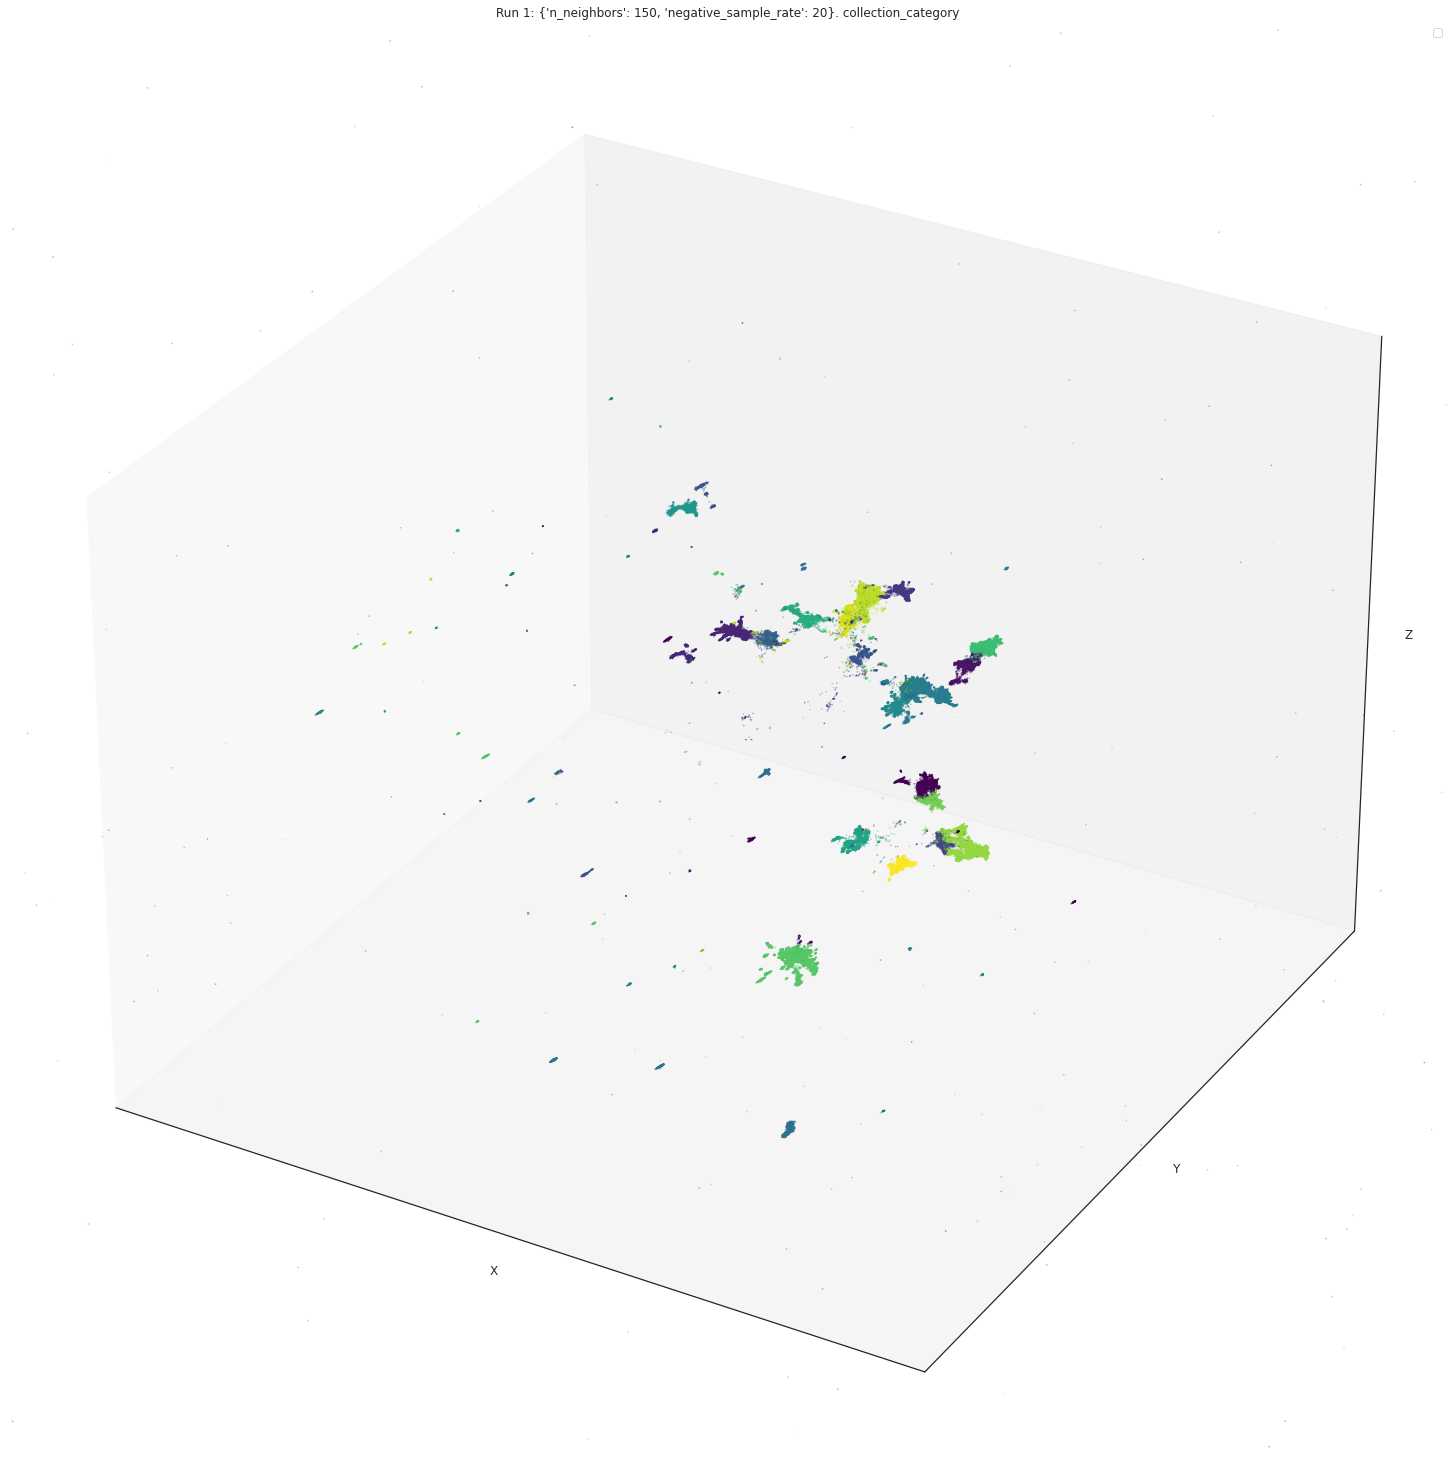

<Figure size 1800x900 with 0 Axes>

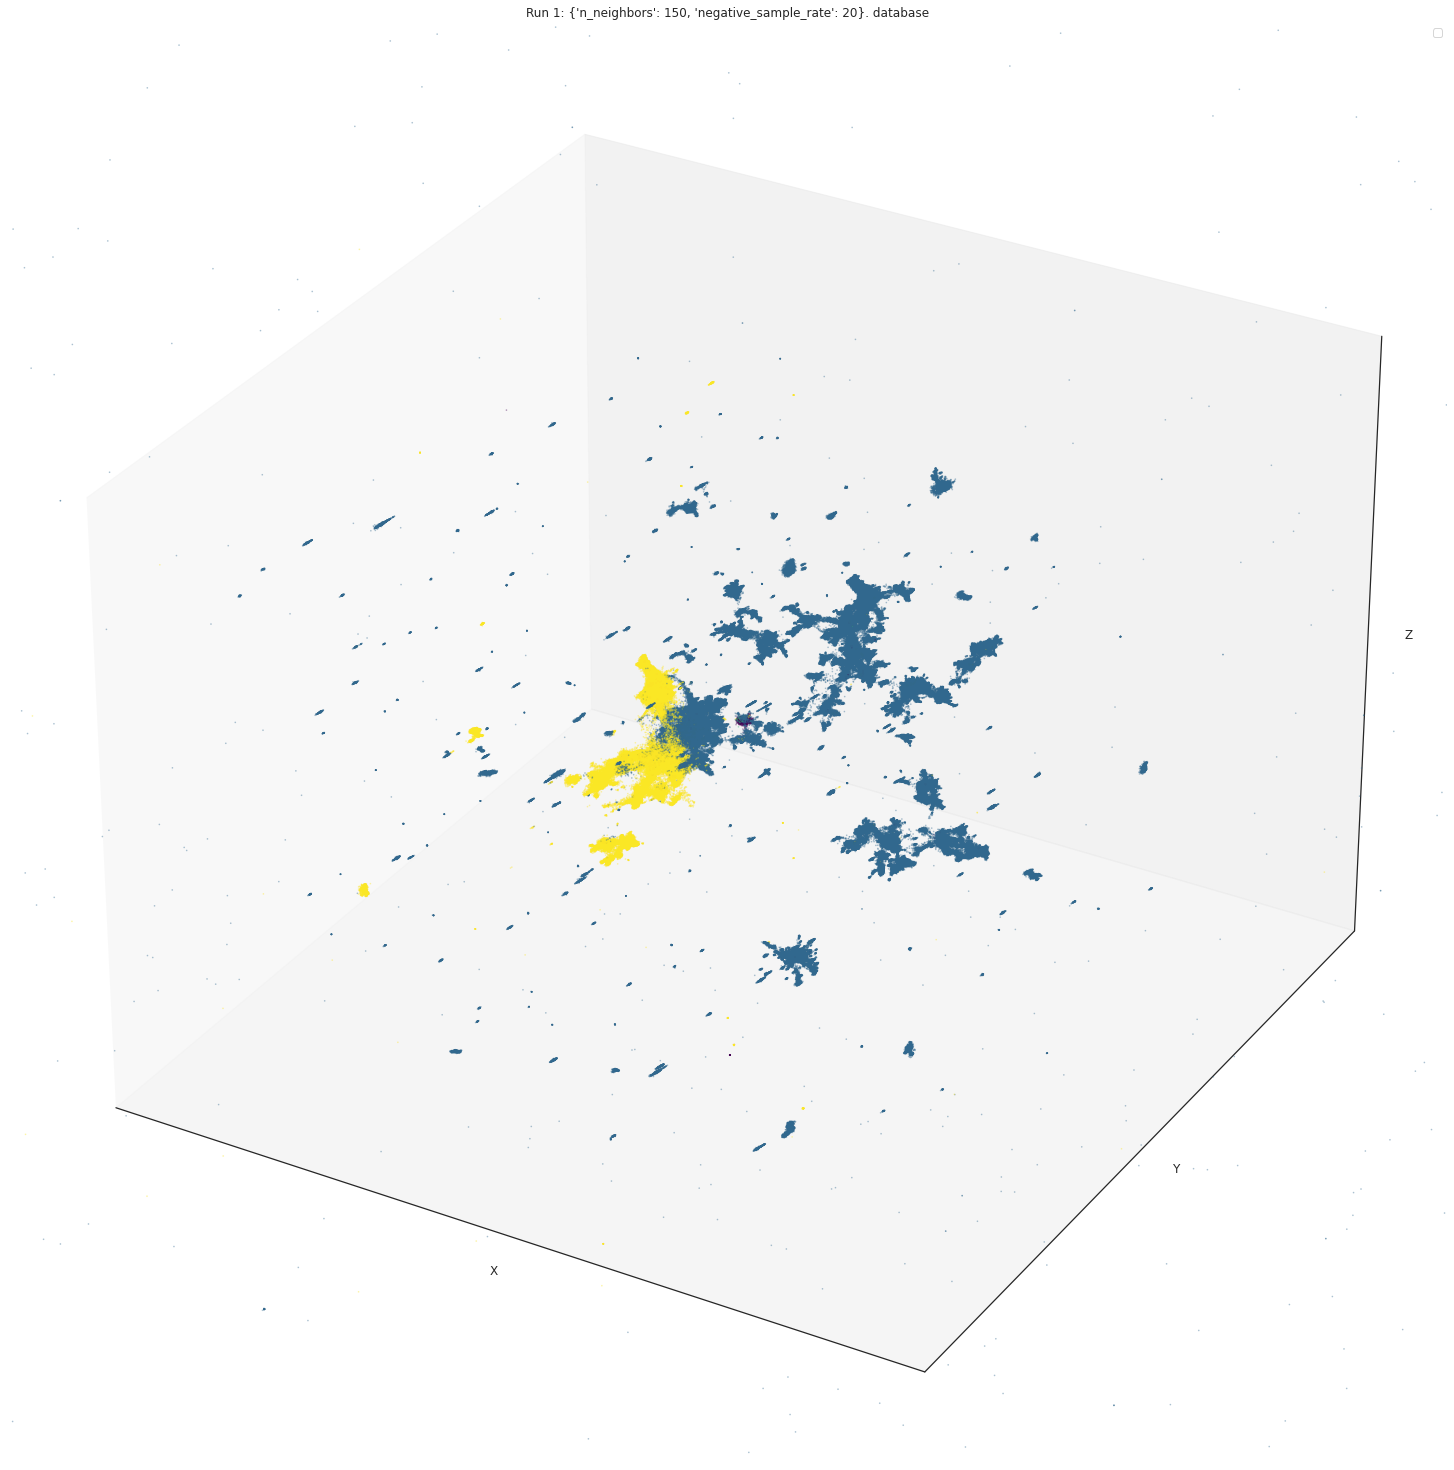

<Figure size 1800x900 with 0 Axes>

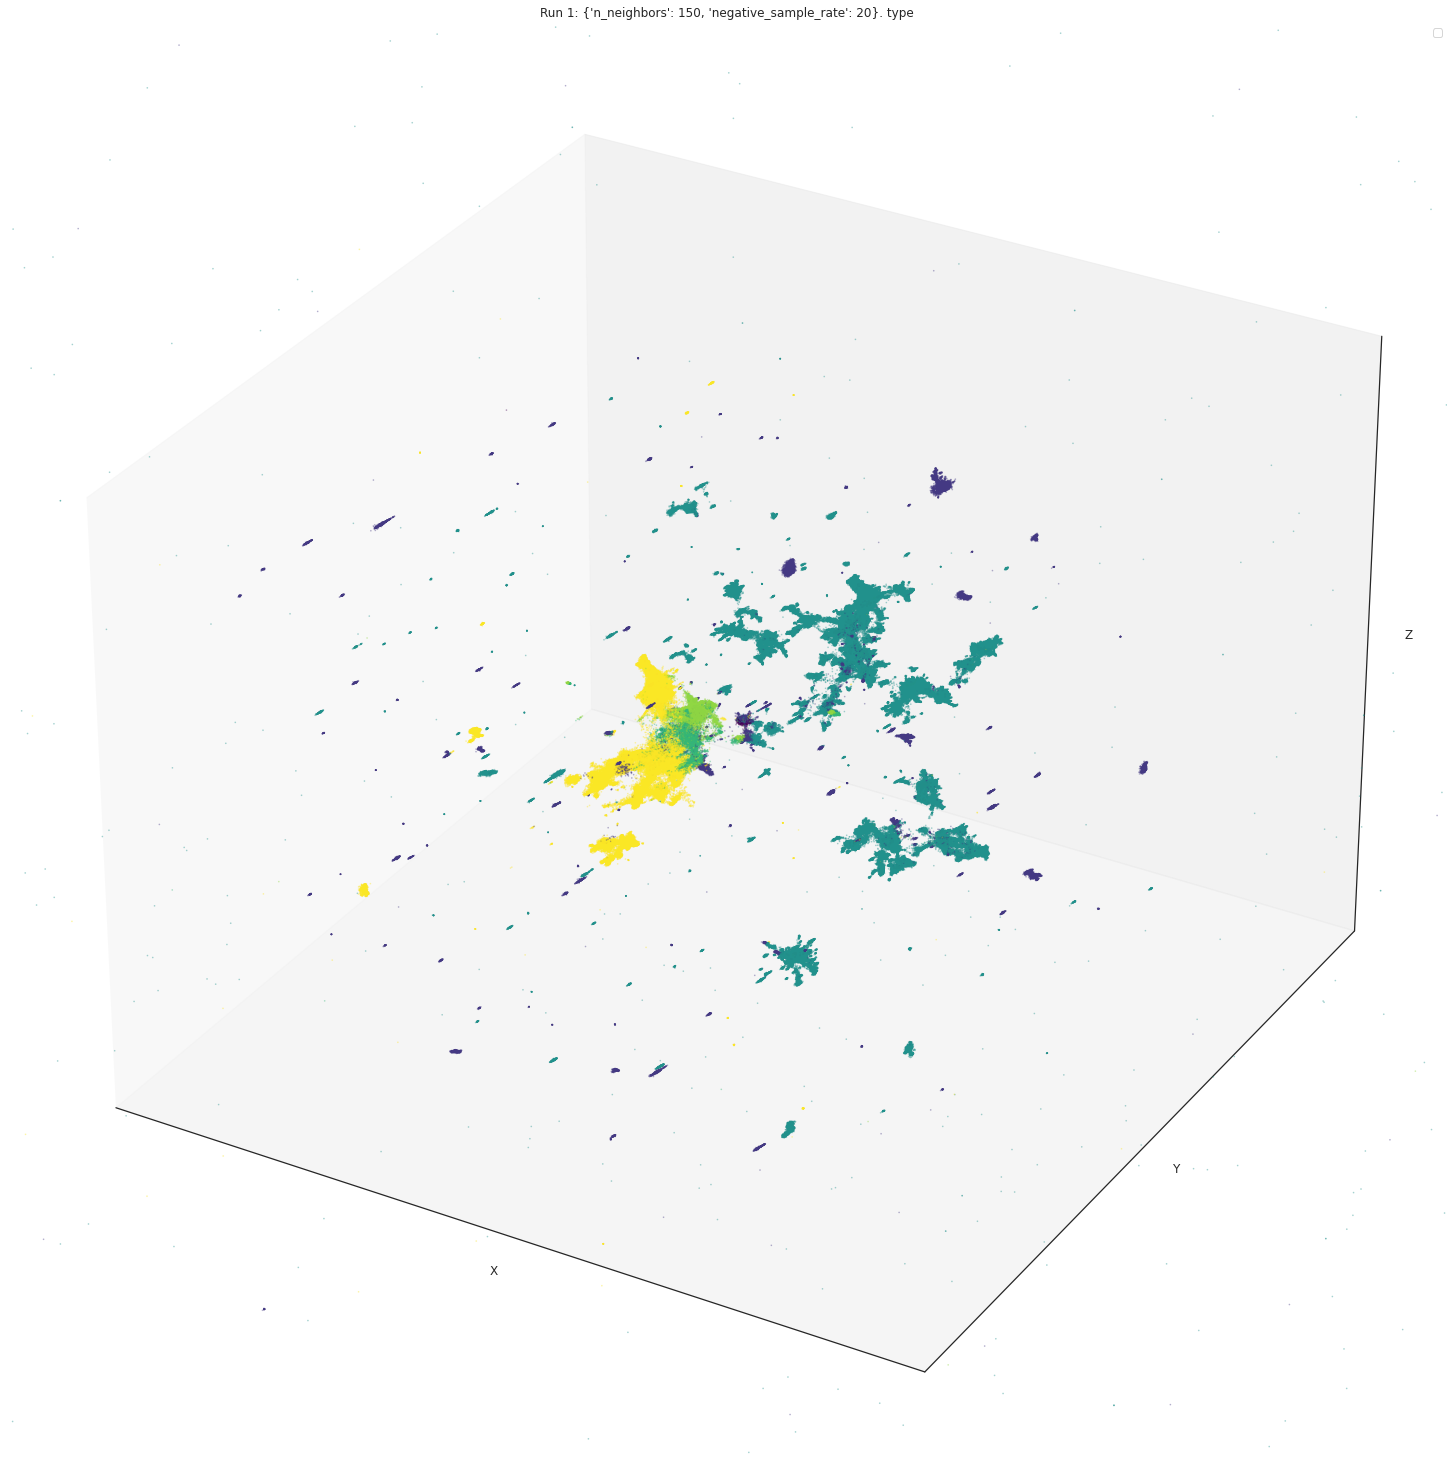

Run 2. Params {'n_neighbors': 150, 'negative_sample_rate': 10}


<Figure size 1800x900 with 0 Axes>

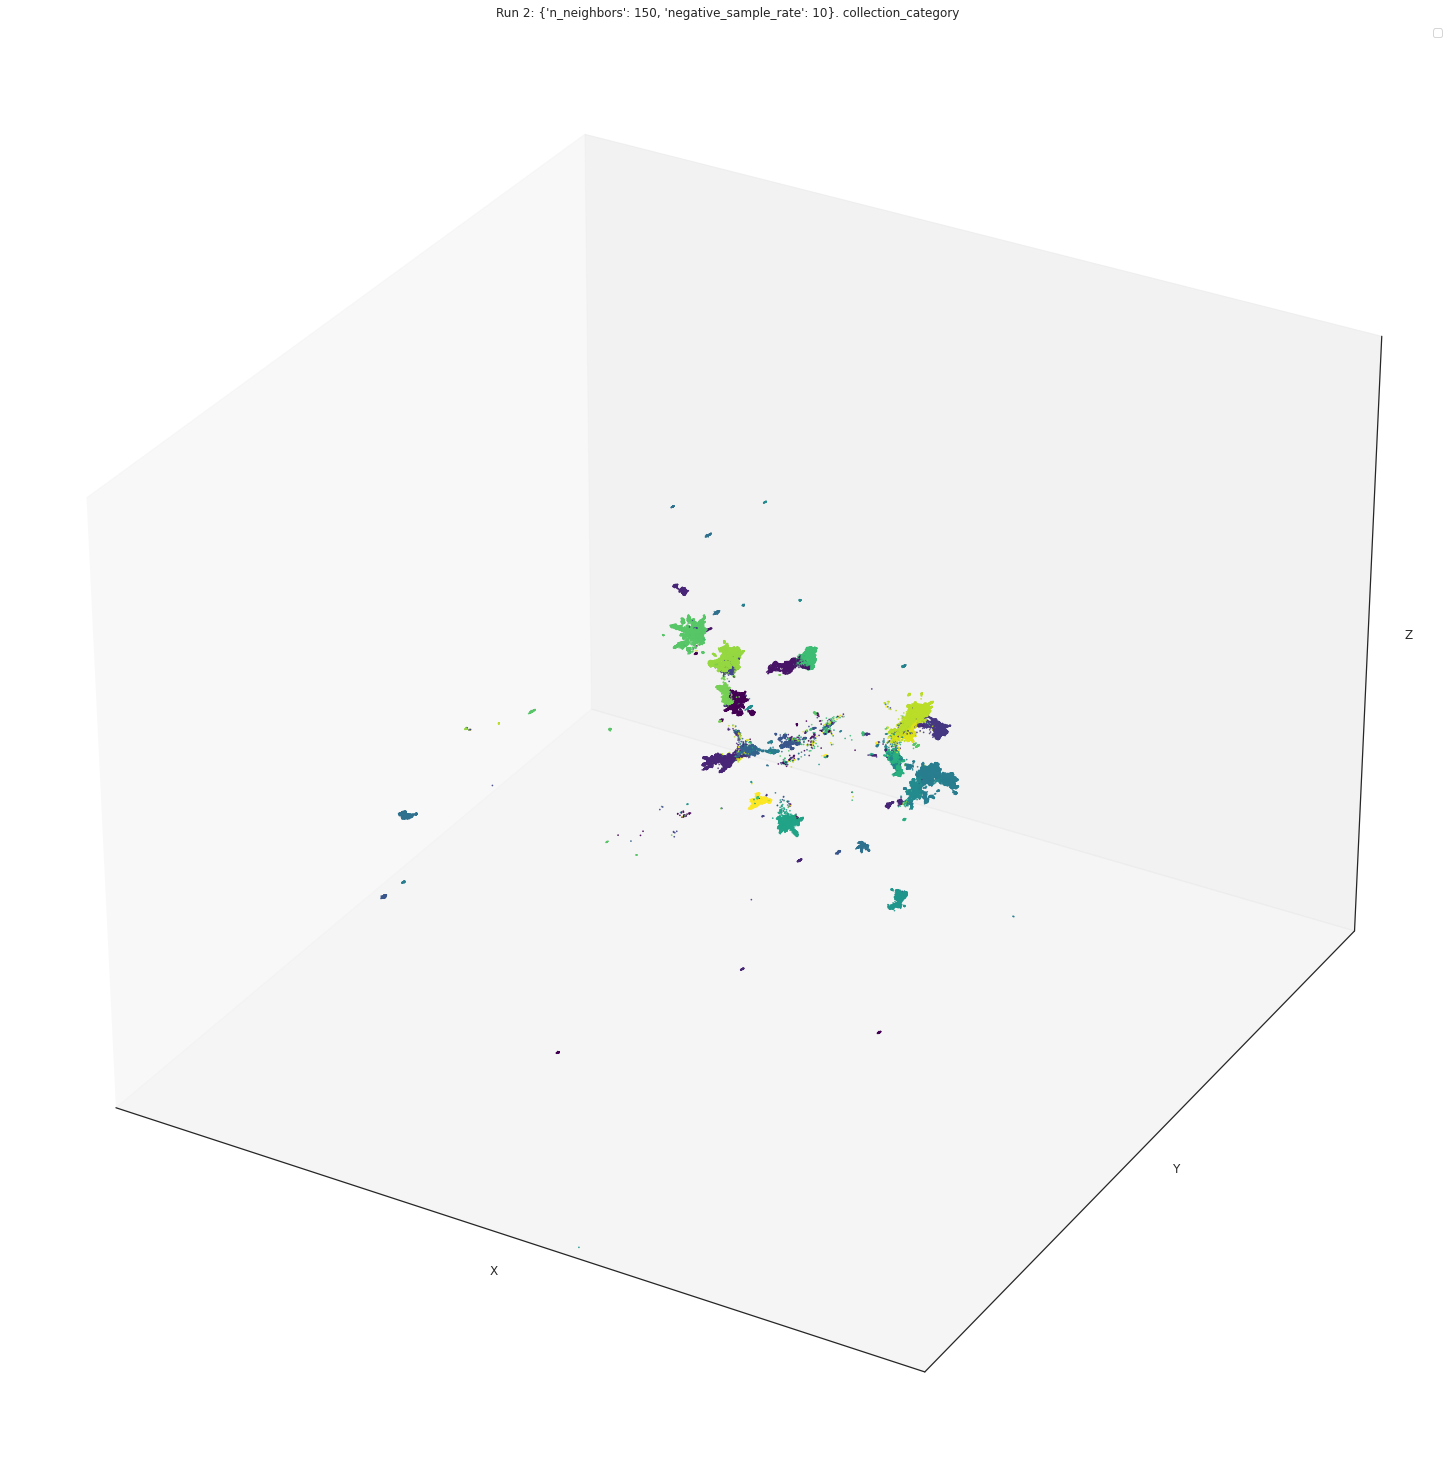

<Figure size 1800x900 with 0 Axes>

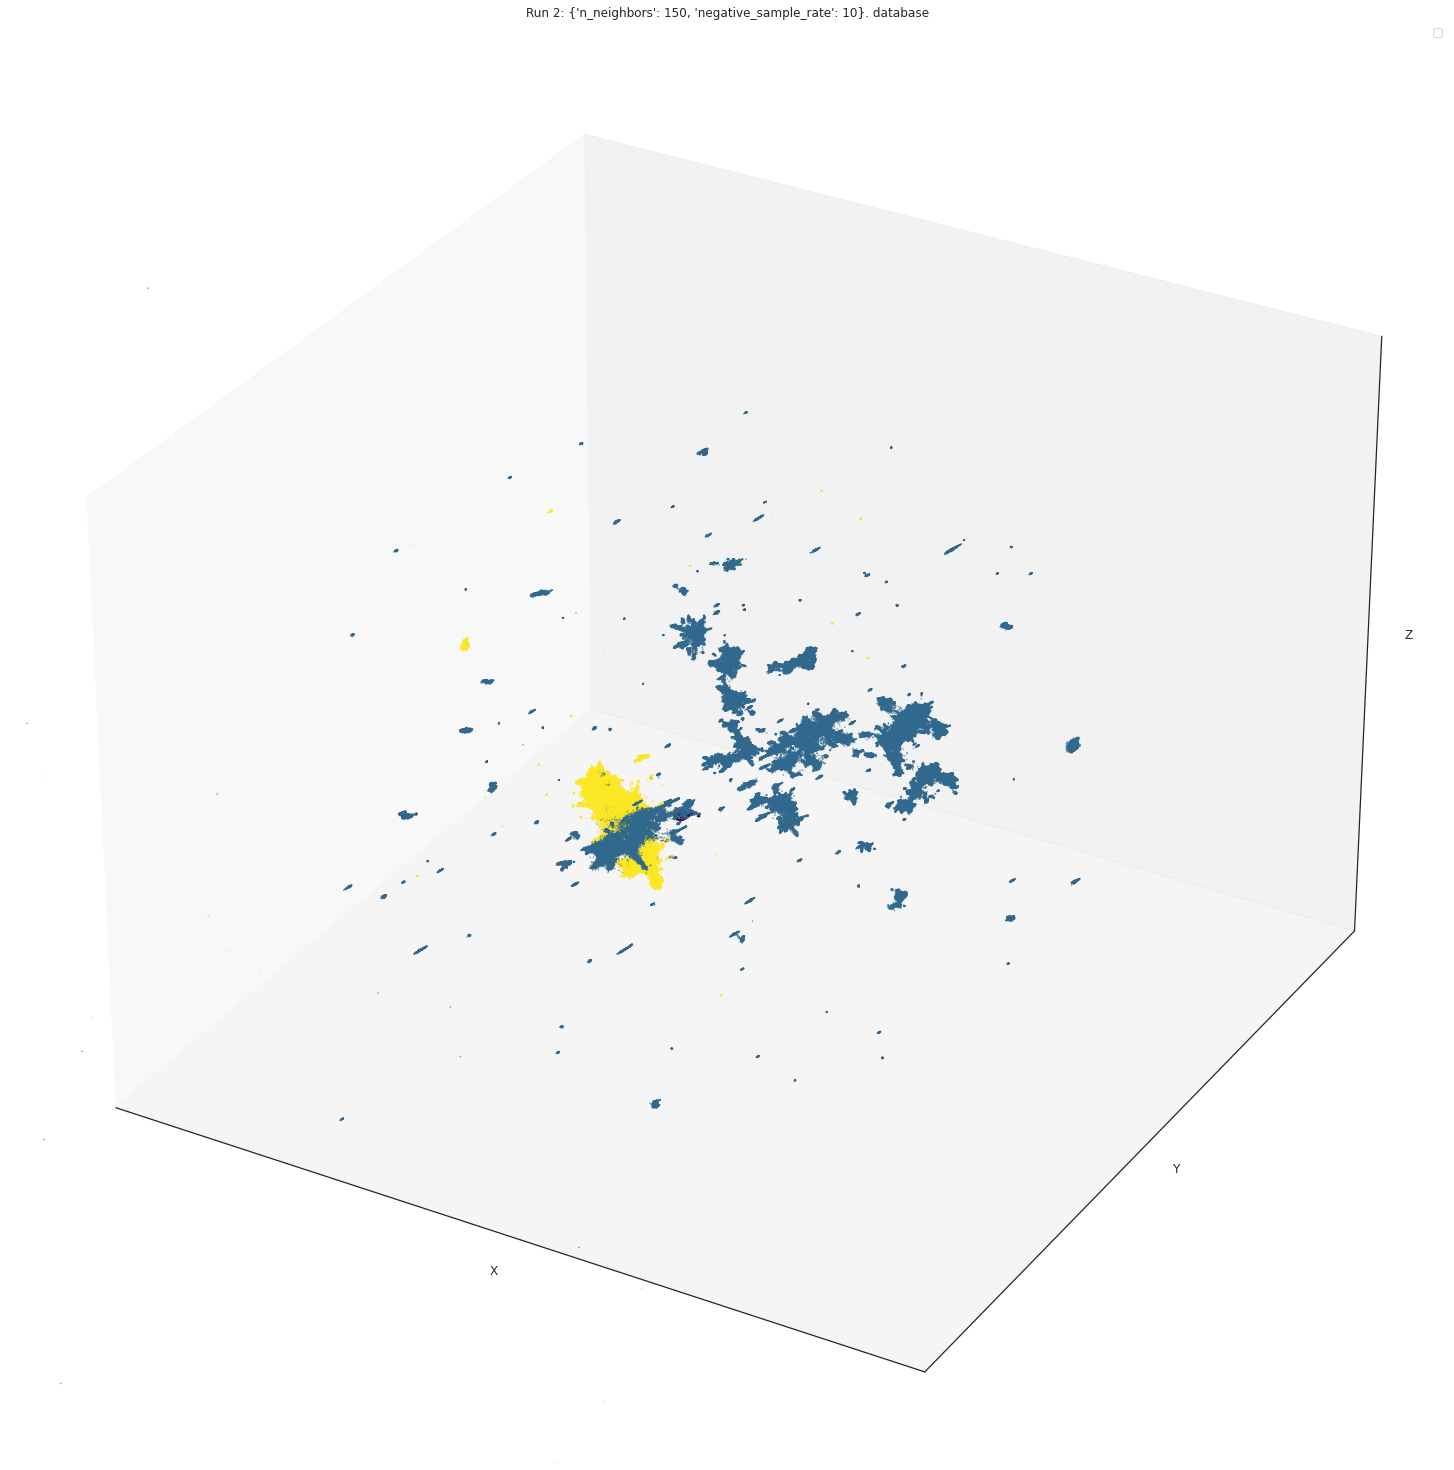

<Figure size 1800x900 with 0 Axes>

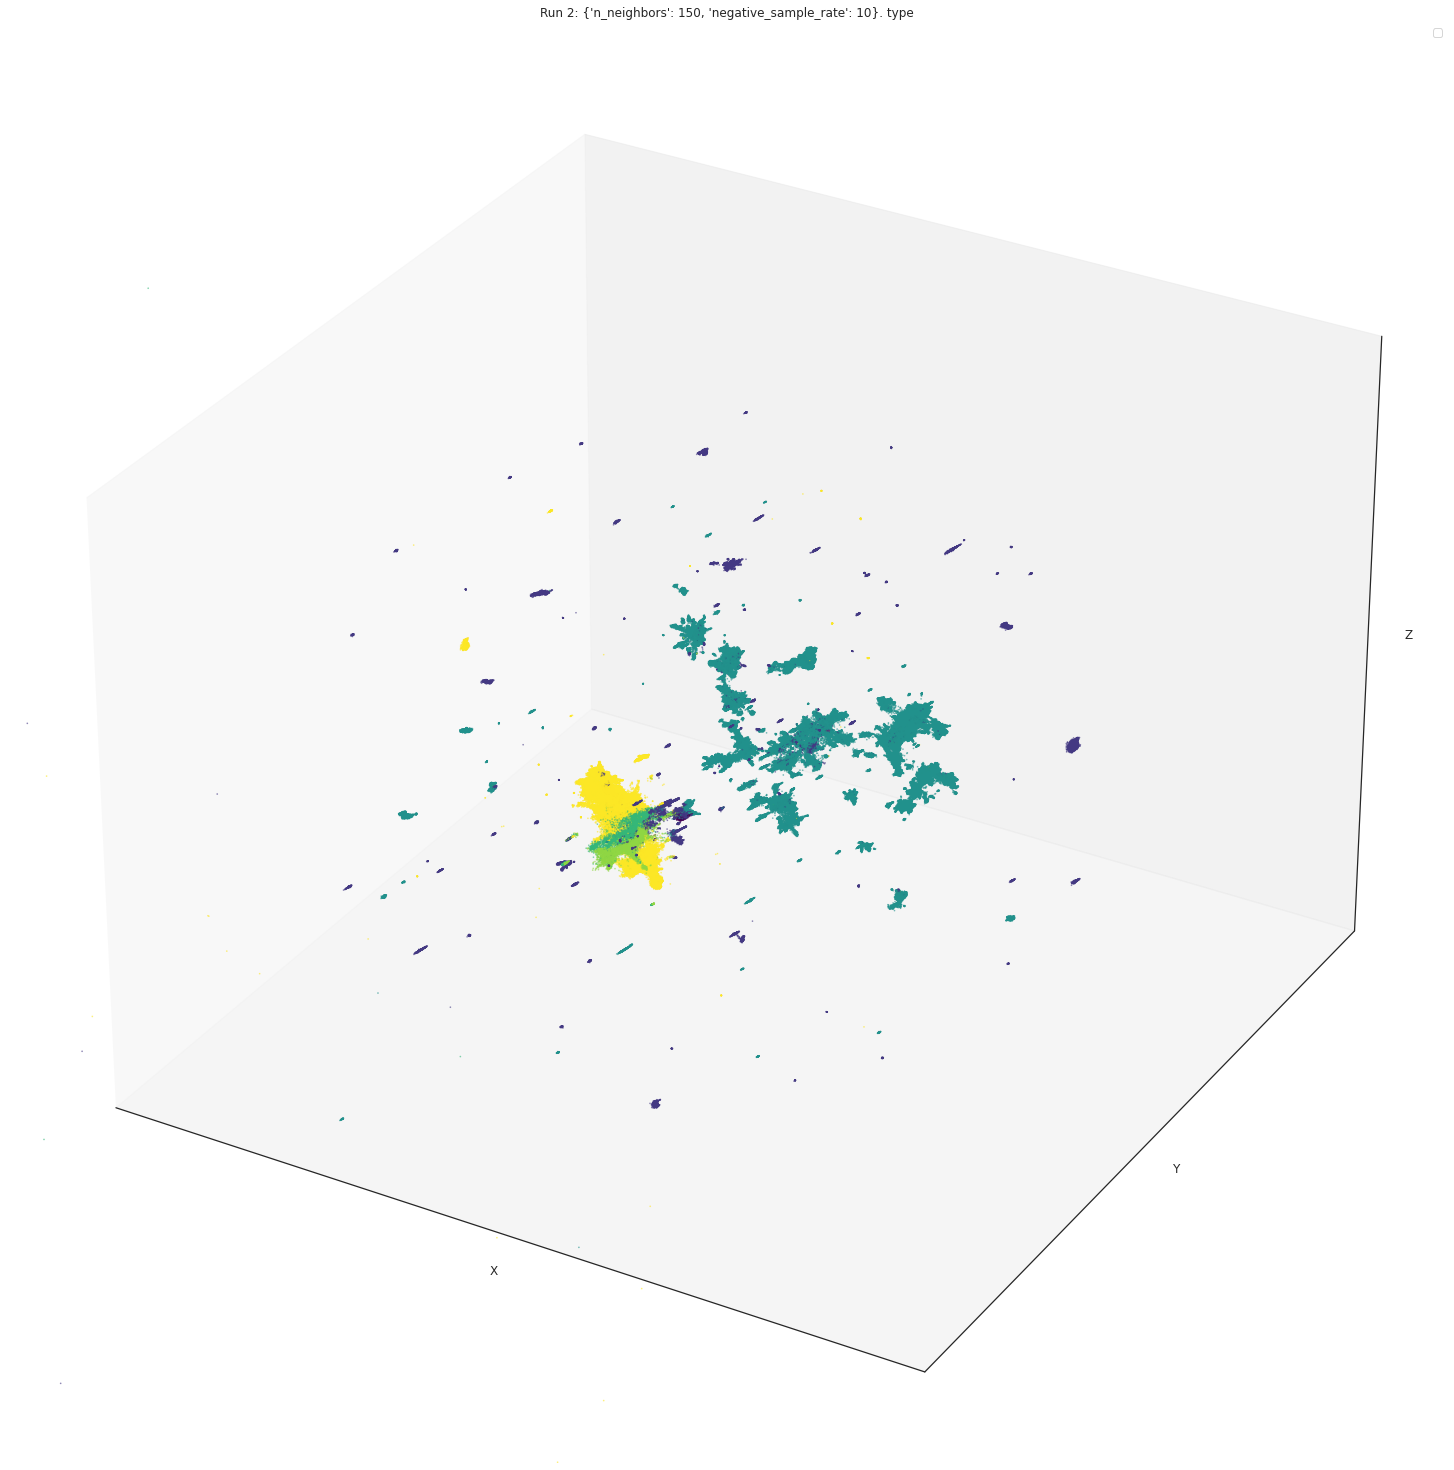

Run 3. Params {'n_neighbors': 50, 'negative_sample_rate': 5}


<Figure size 1800x900 with 0 Axes>

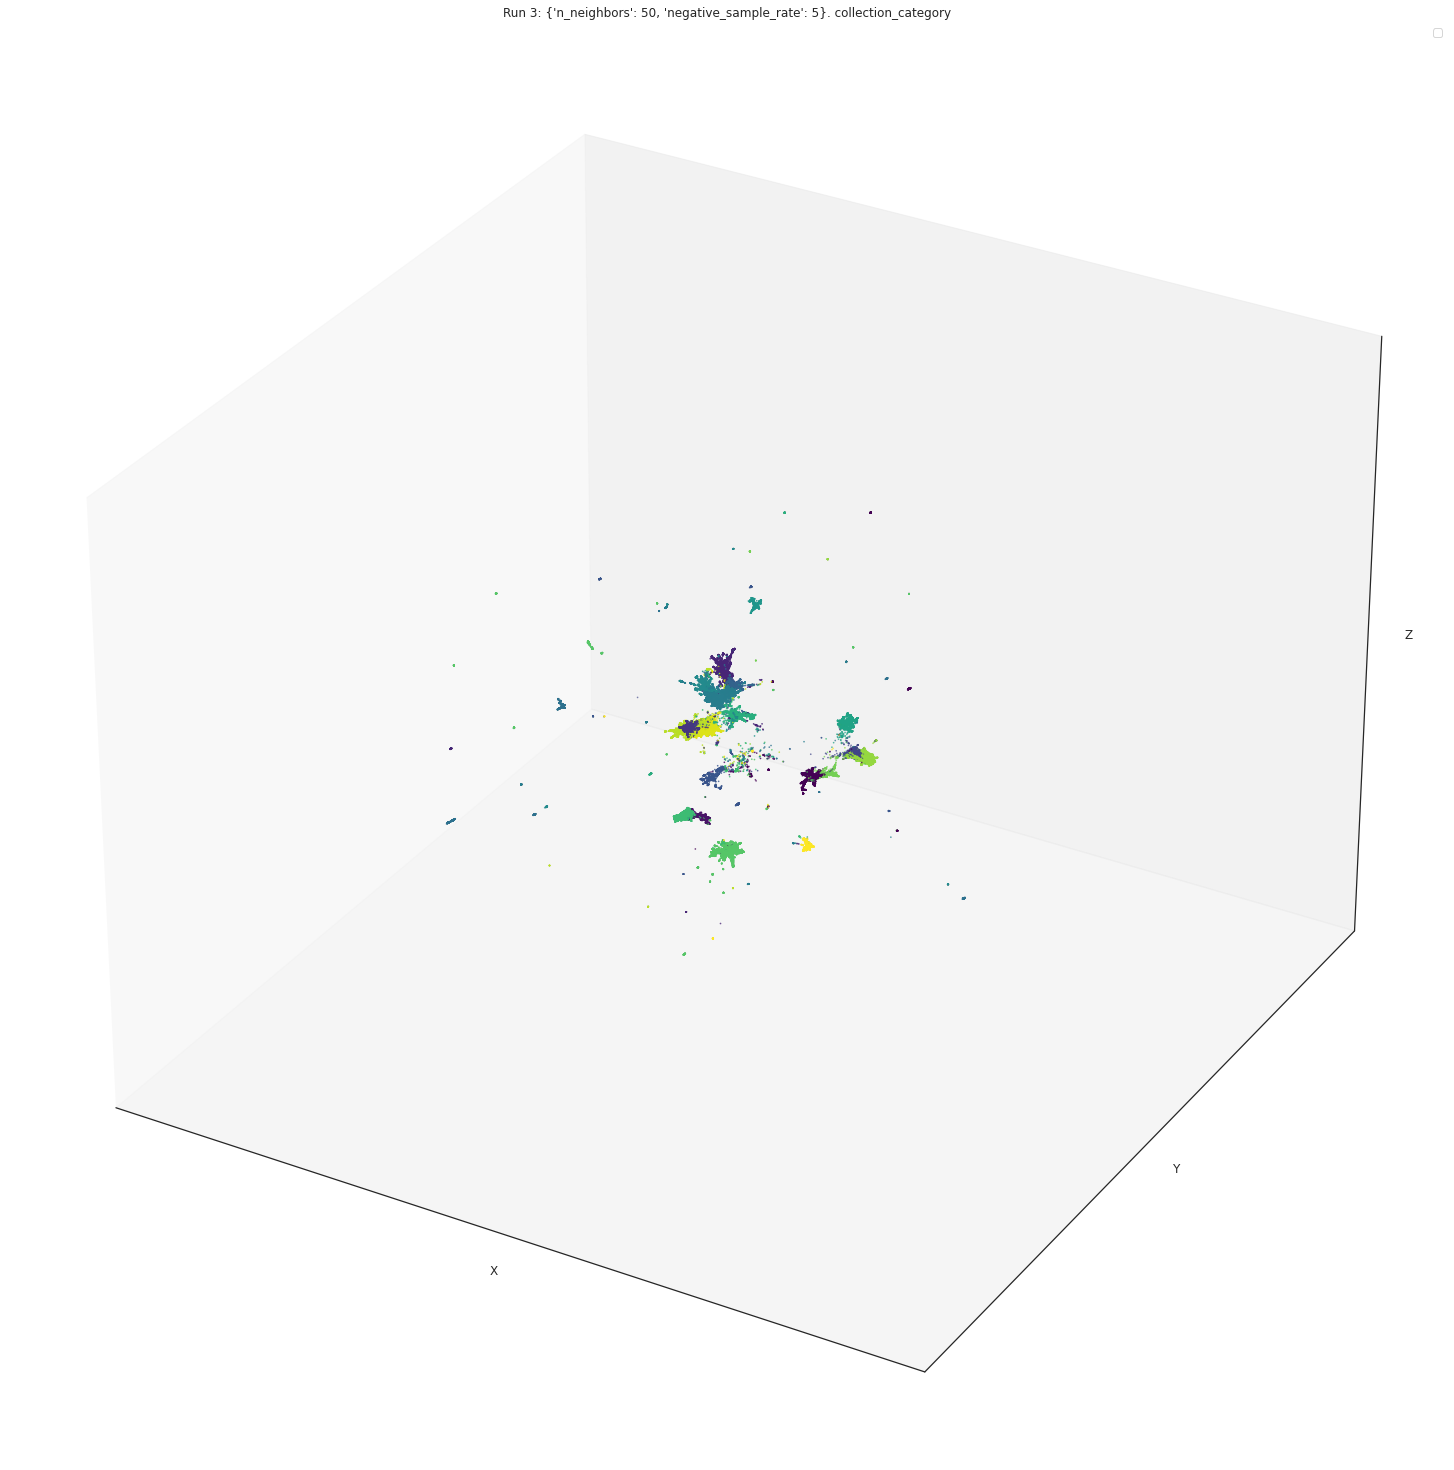

<Figure size 1800x900 with 0 Axes>

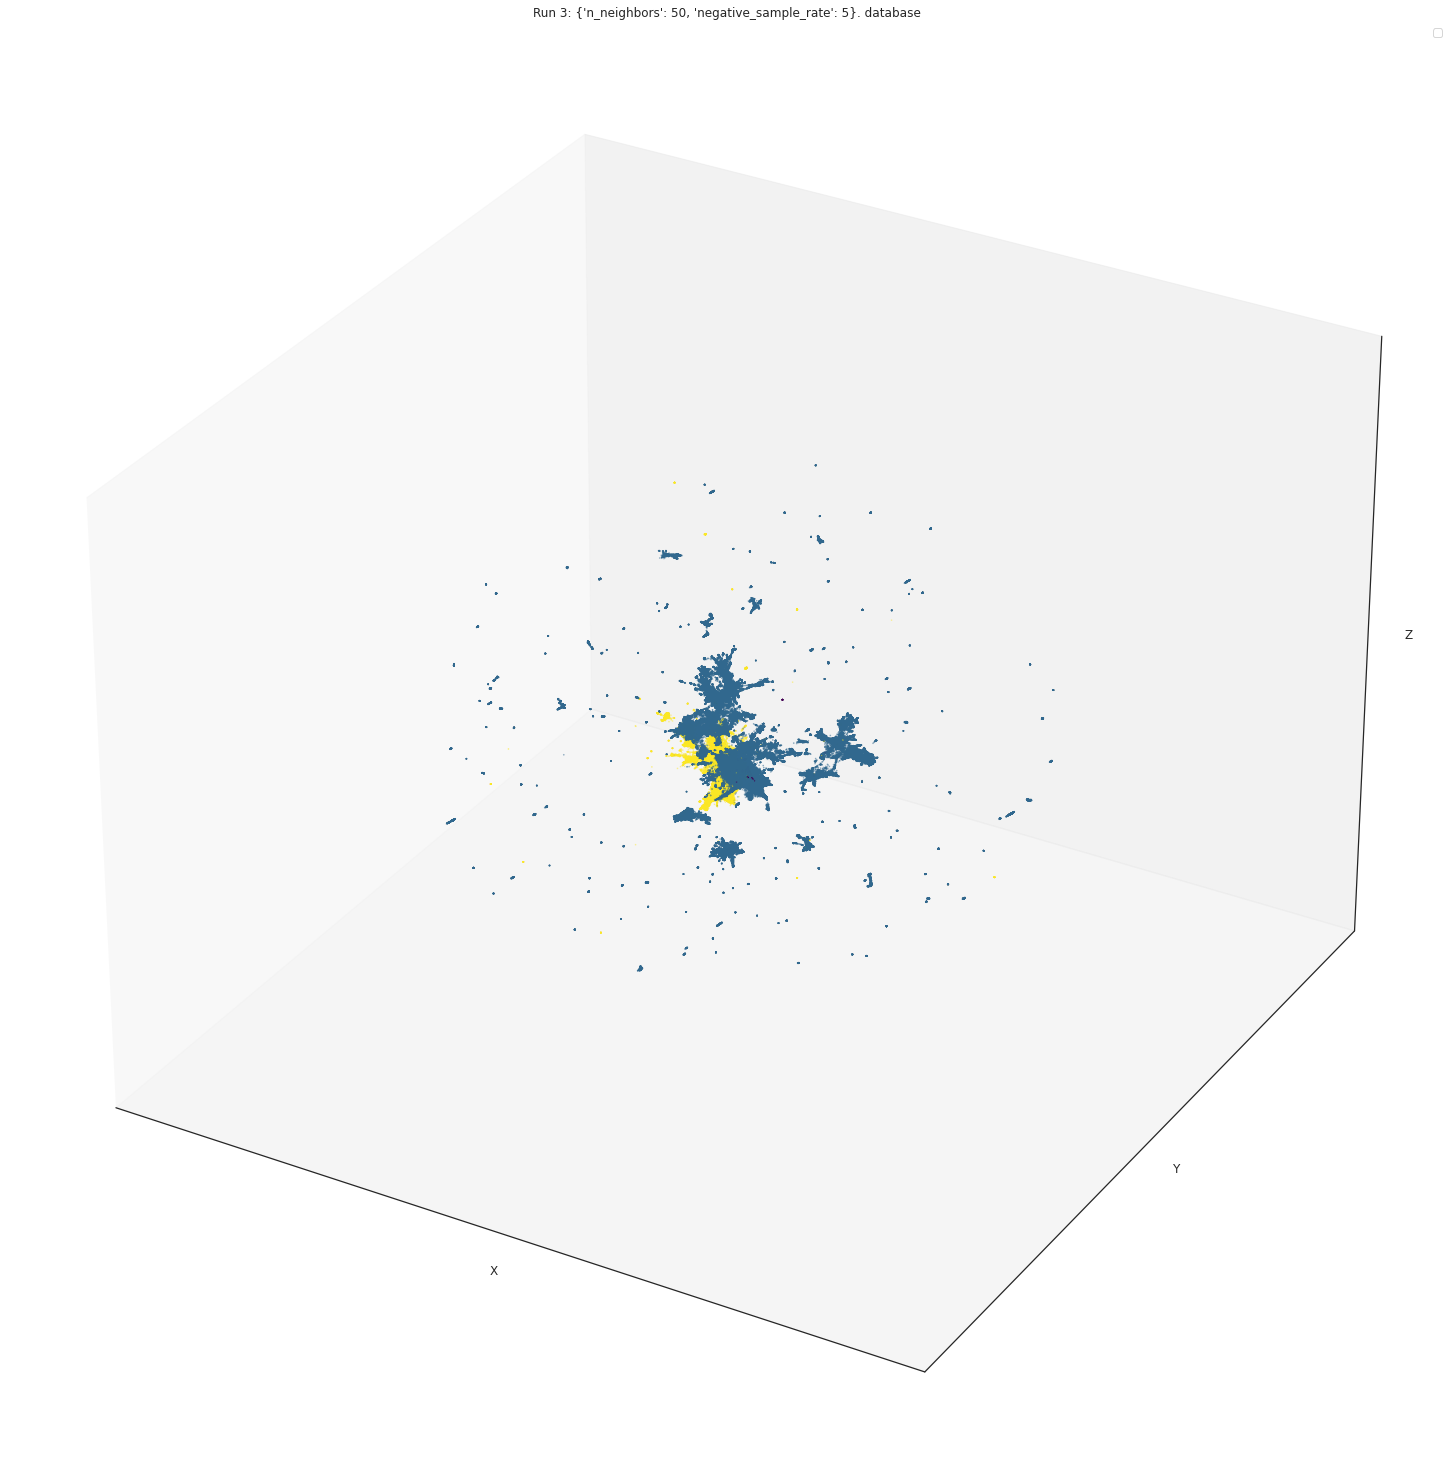

<Figure size 1800x900 with 0 Axes>

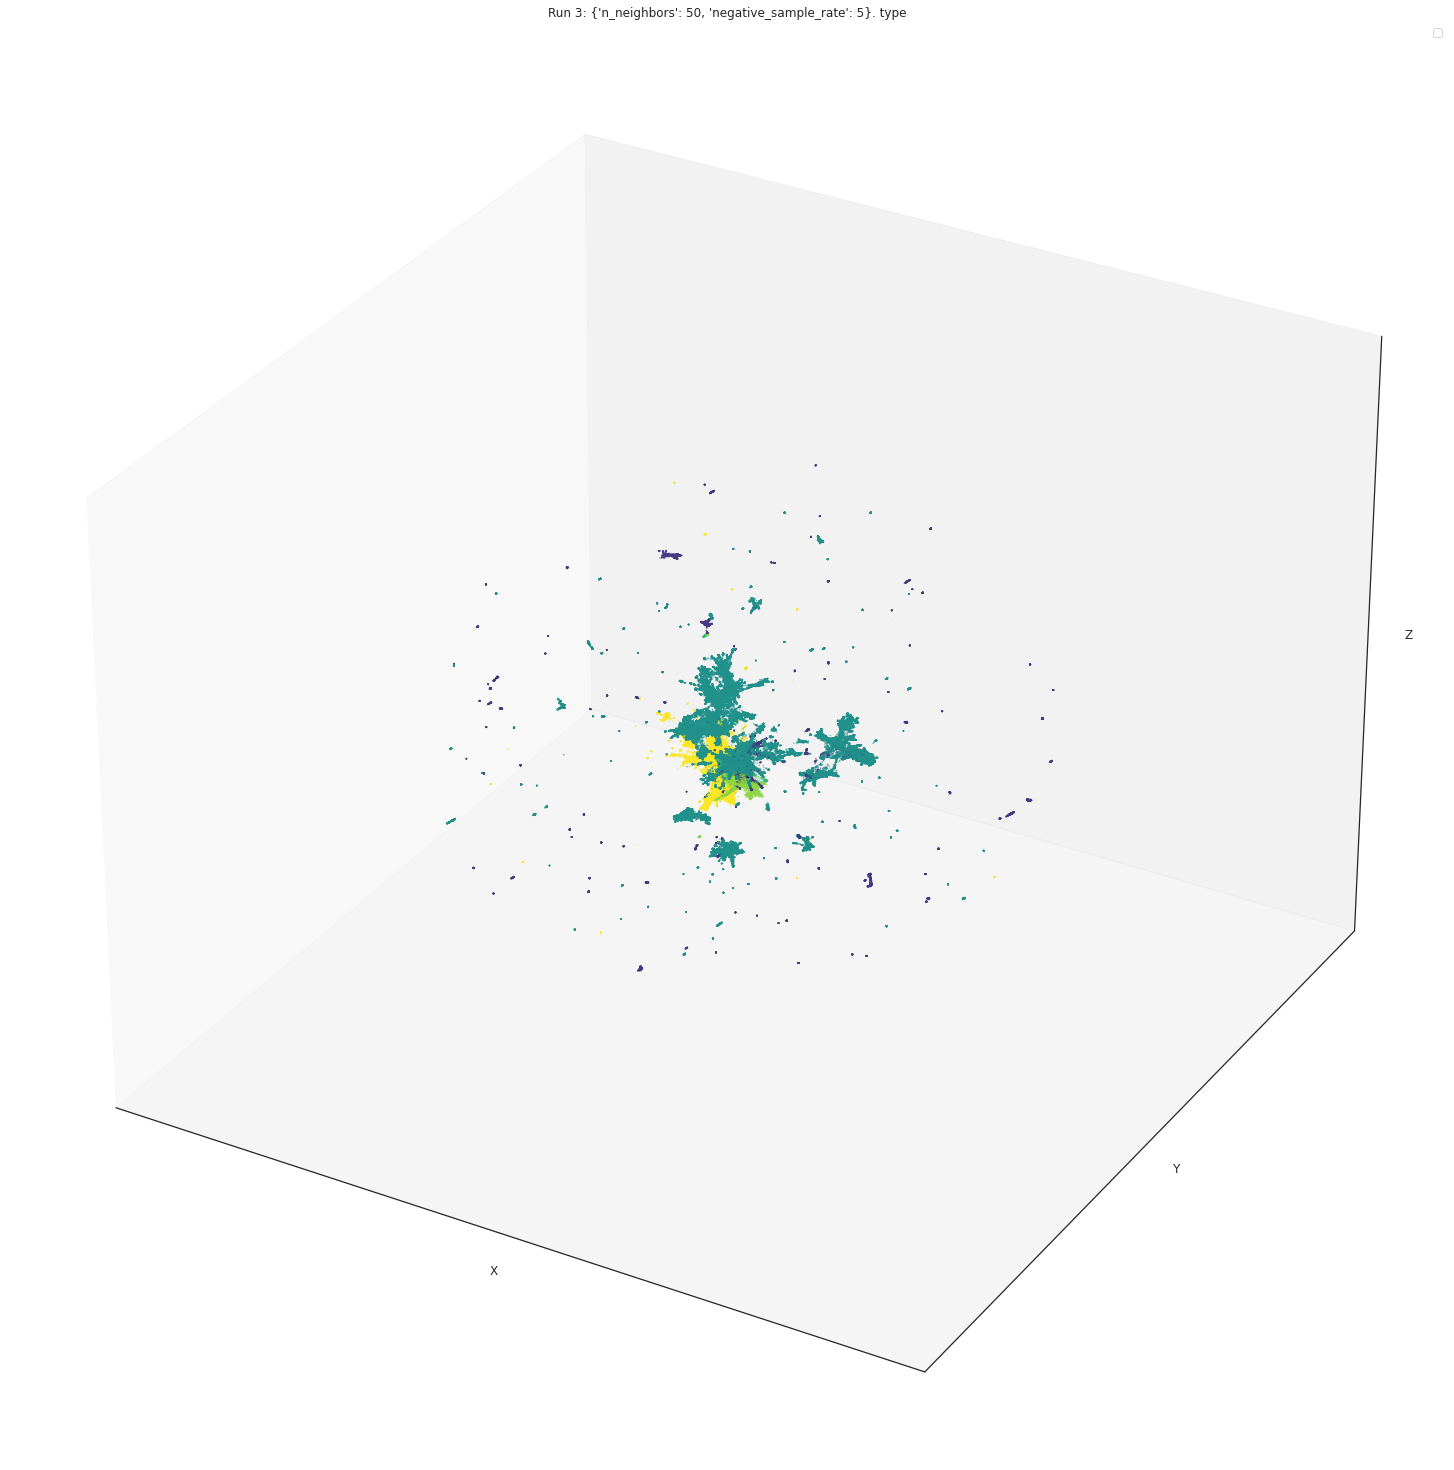

Run 4. Params {'n_neighbors': 150, 'negative_sample_rate': 5}


<Figure size 1800x900 with 0 Axes>

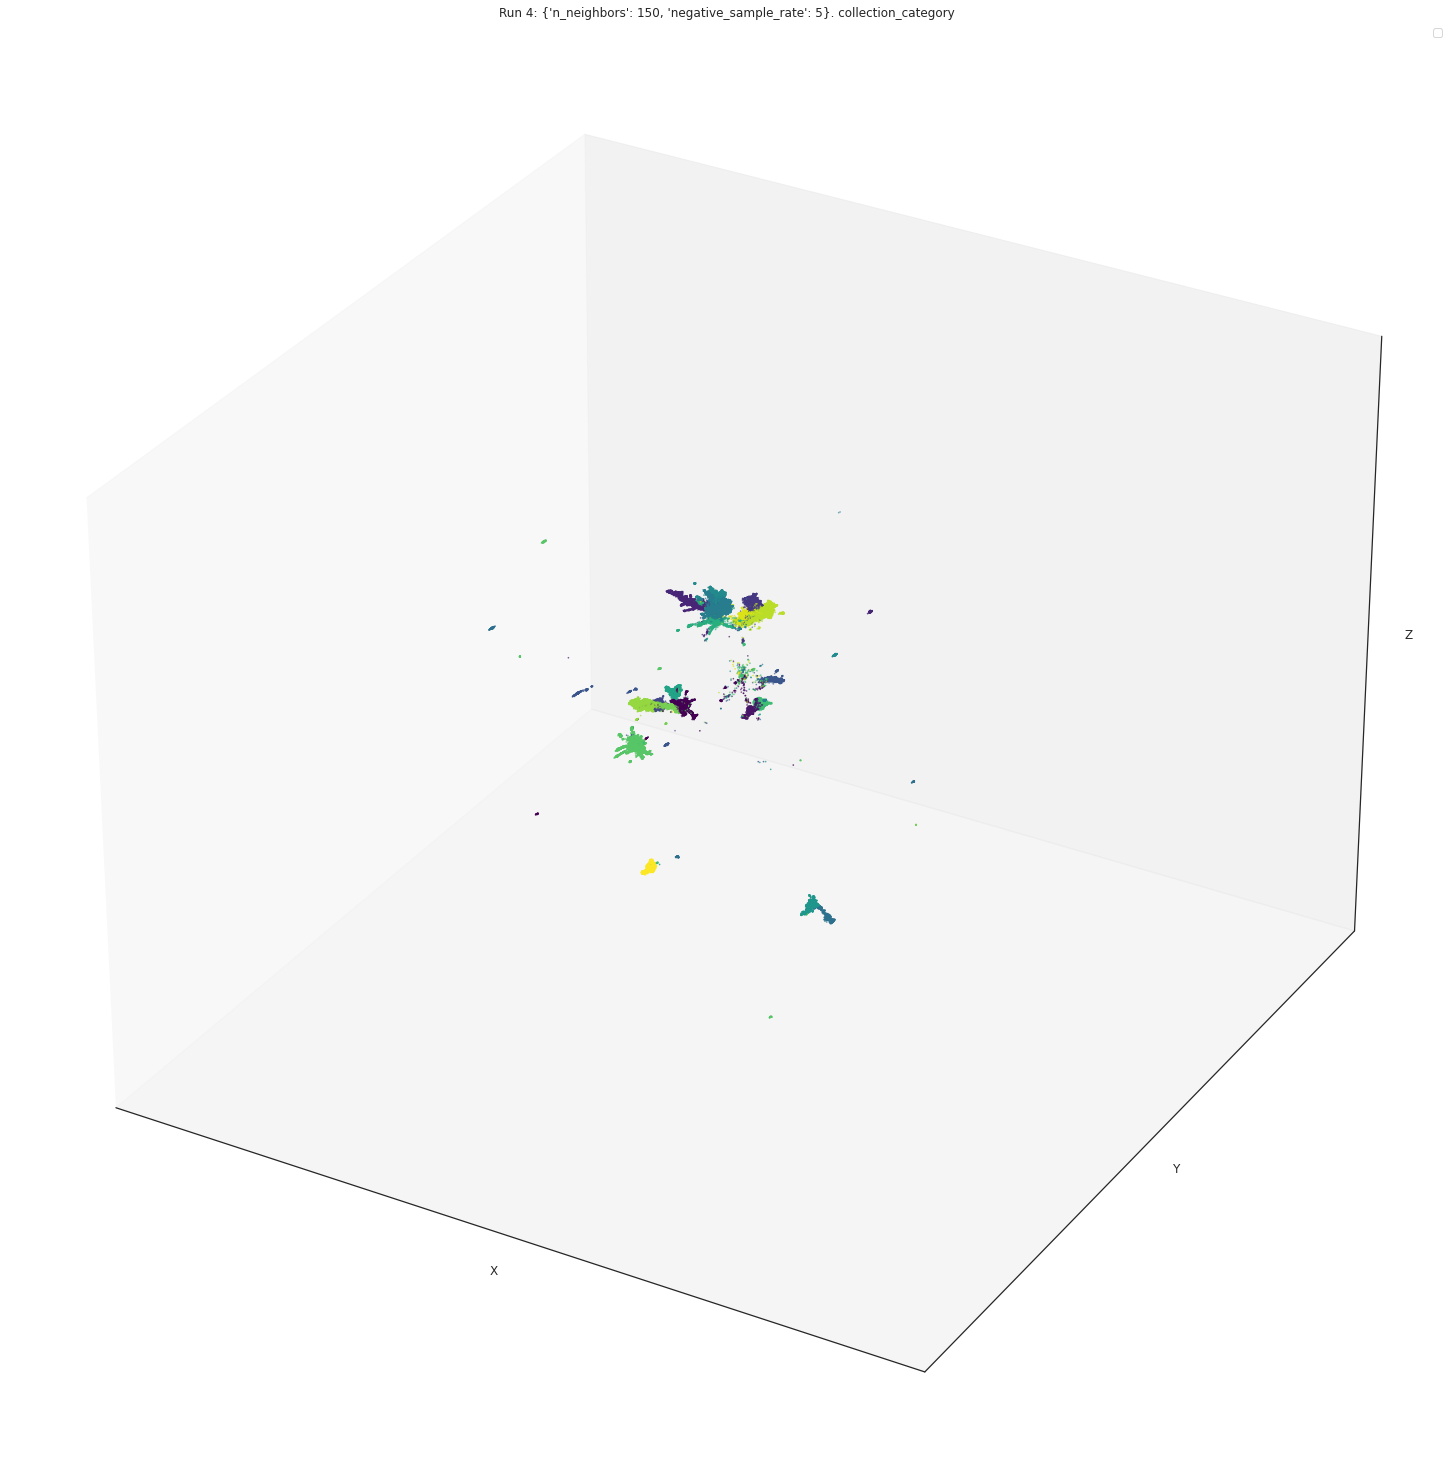

<Figure size 1800x900 with 0 Axes>

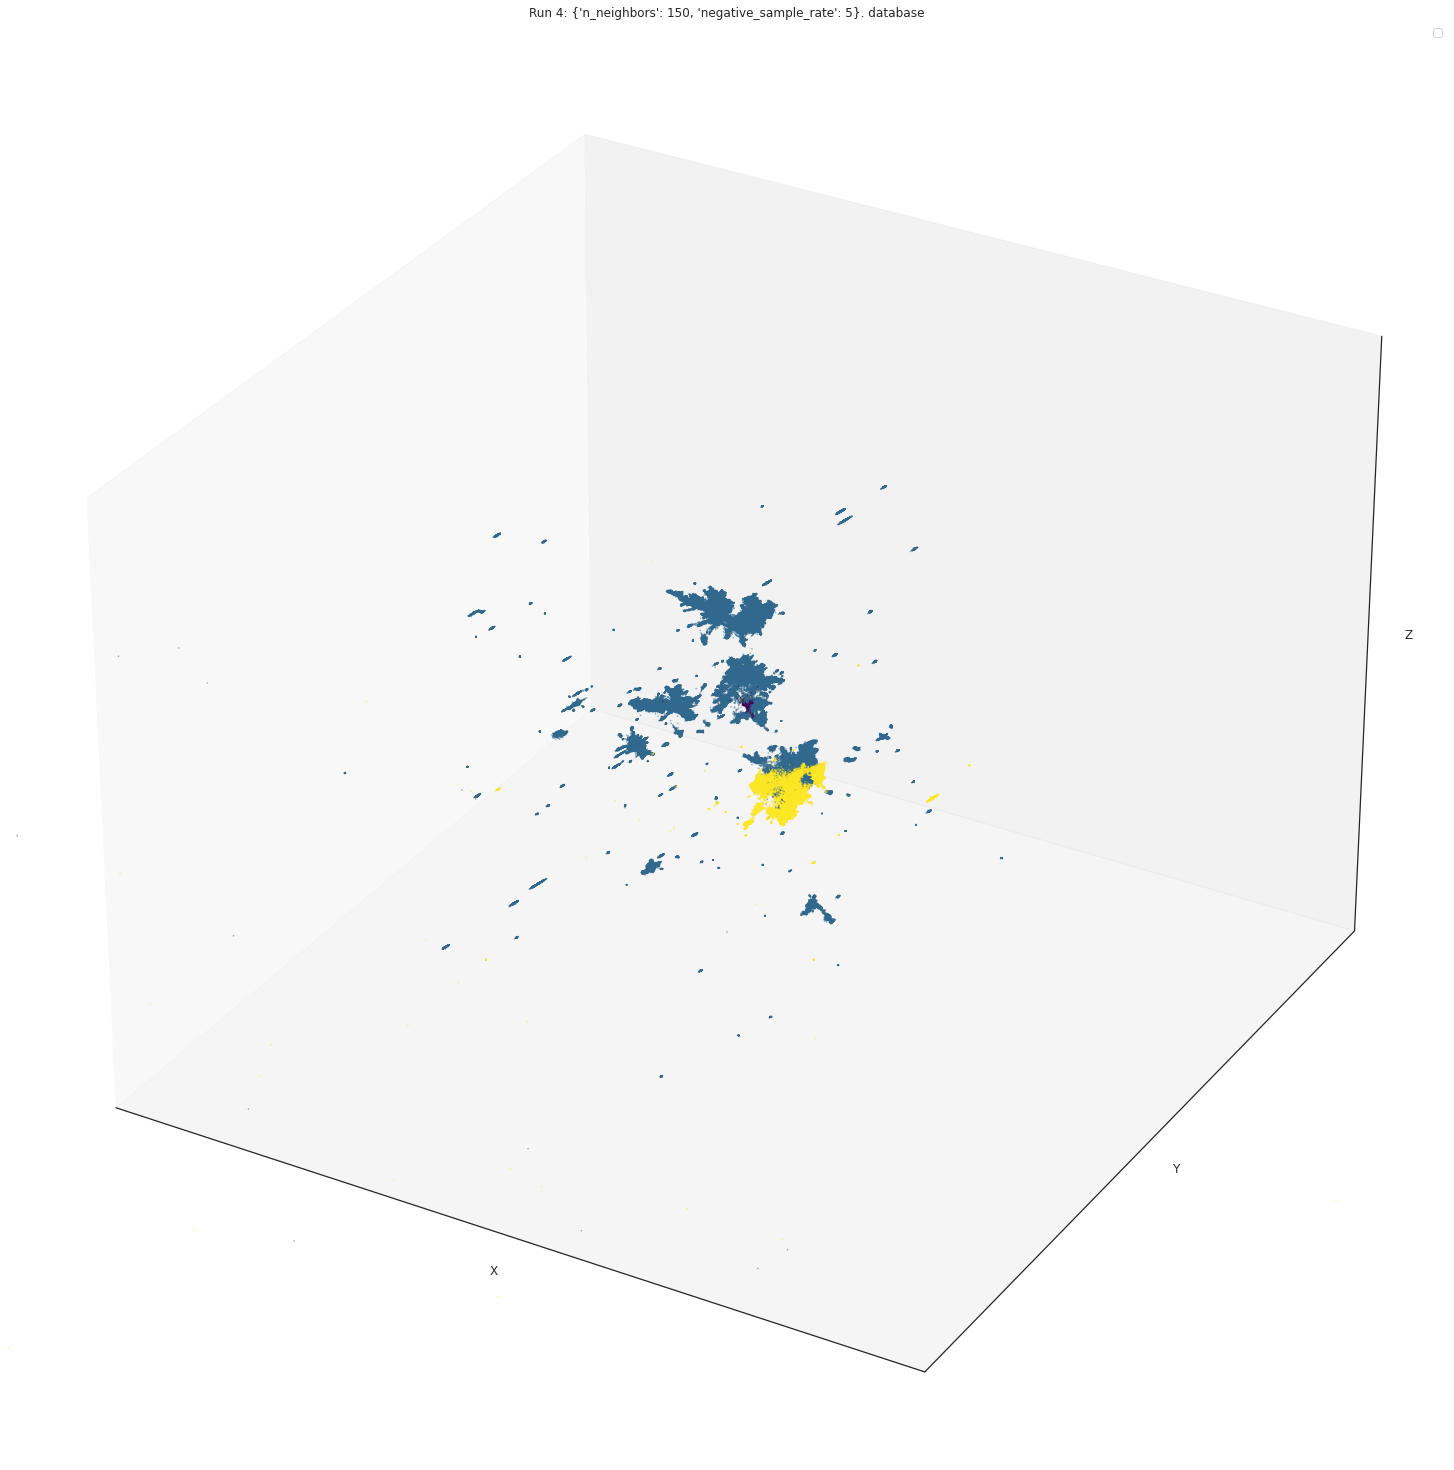

<Figure size 1800x900 with 0 Axes>

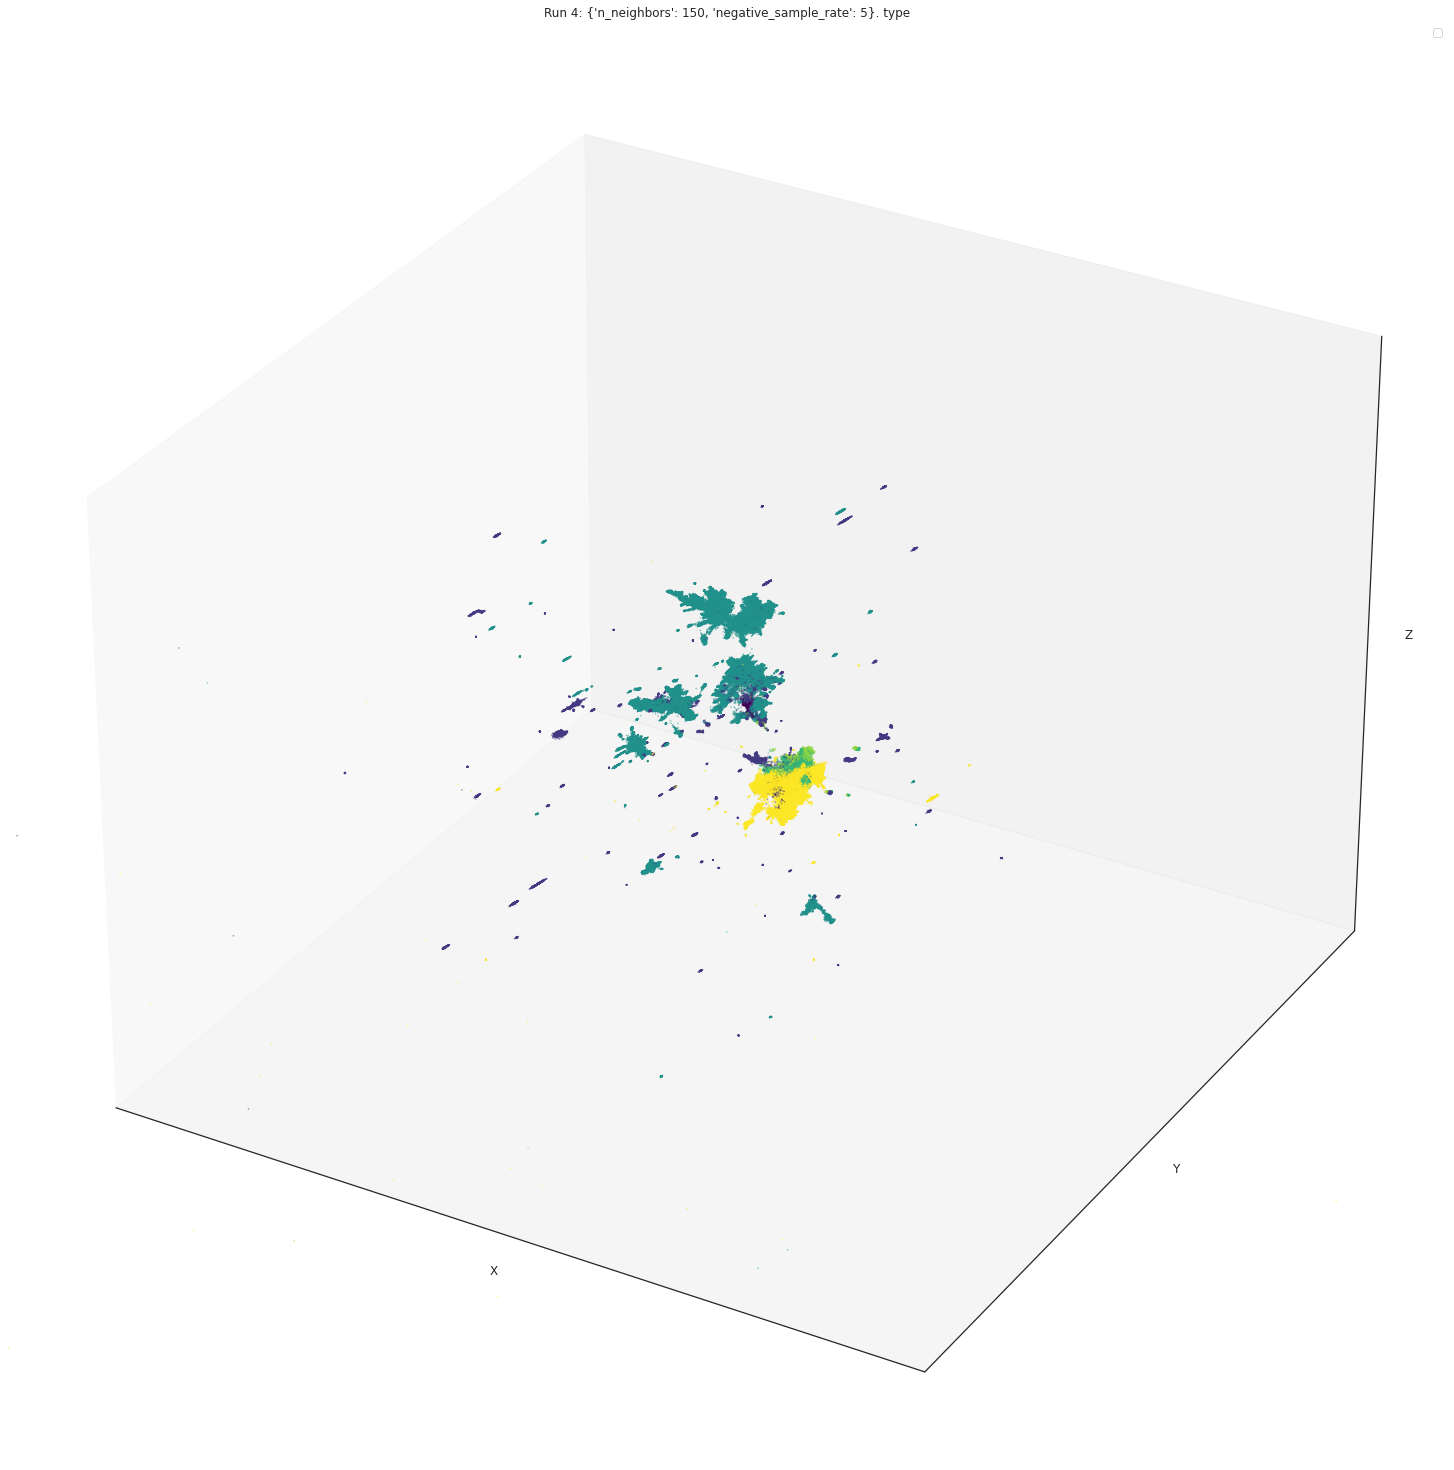

Run 5. Params {'n_neighbors': 100, 'negative_sample_rate': 10}


<Figure size 1800x900 with 0 Axes>

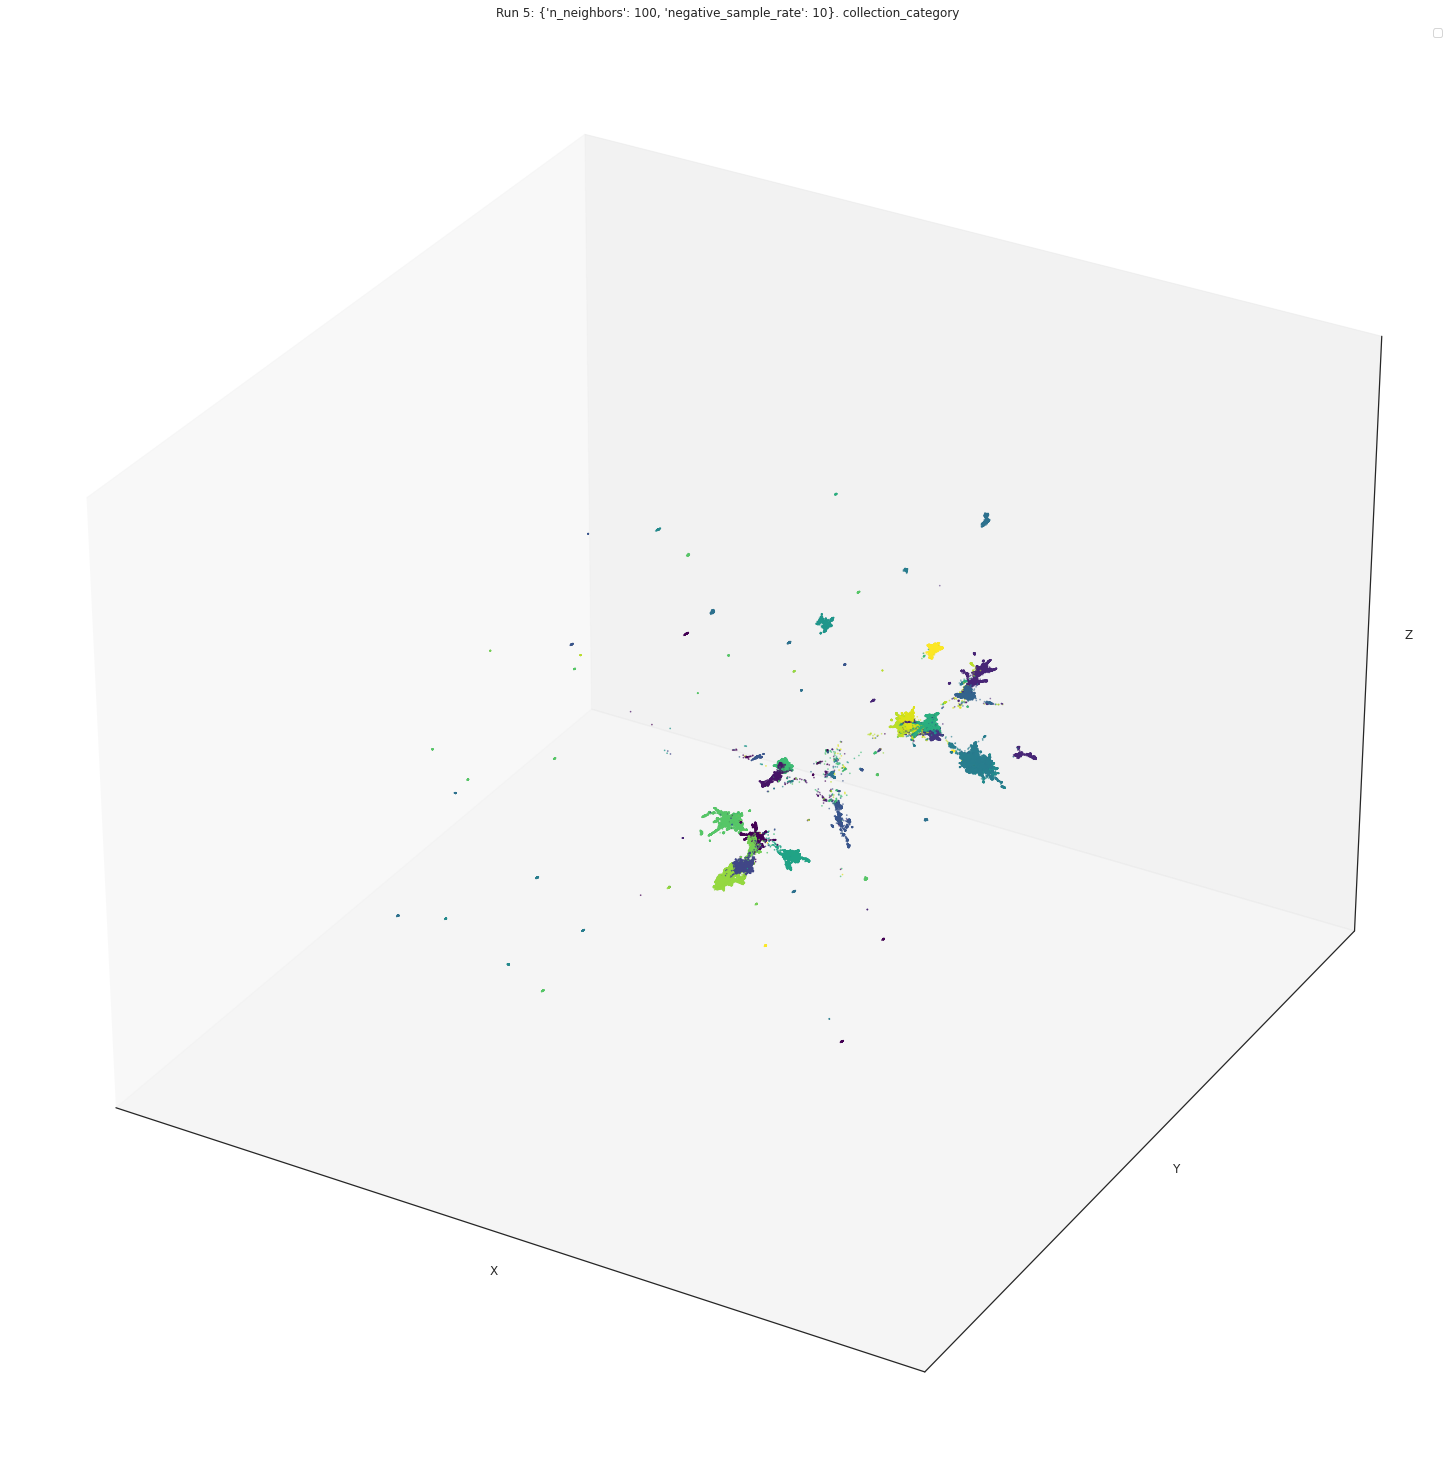

<Figure size 1800x900 with 0 Axes>

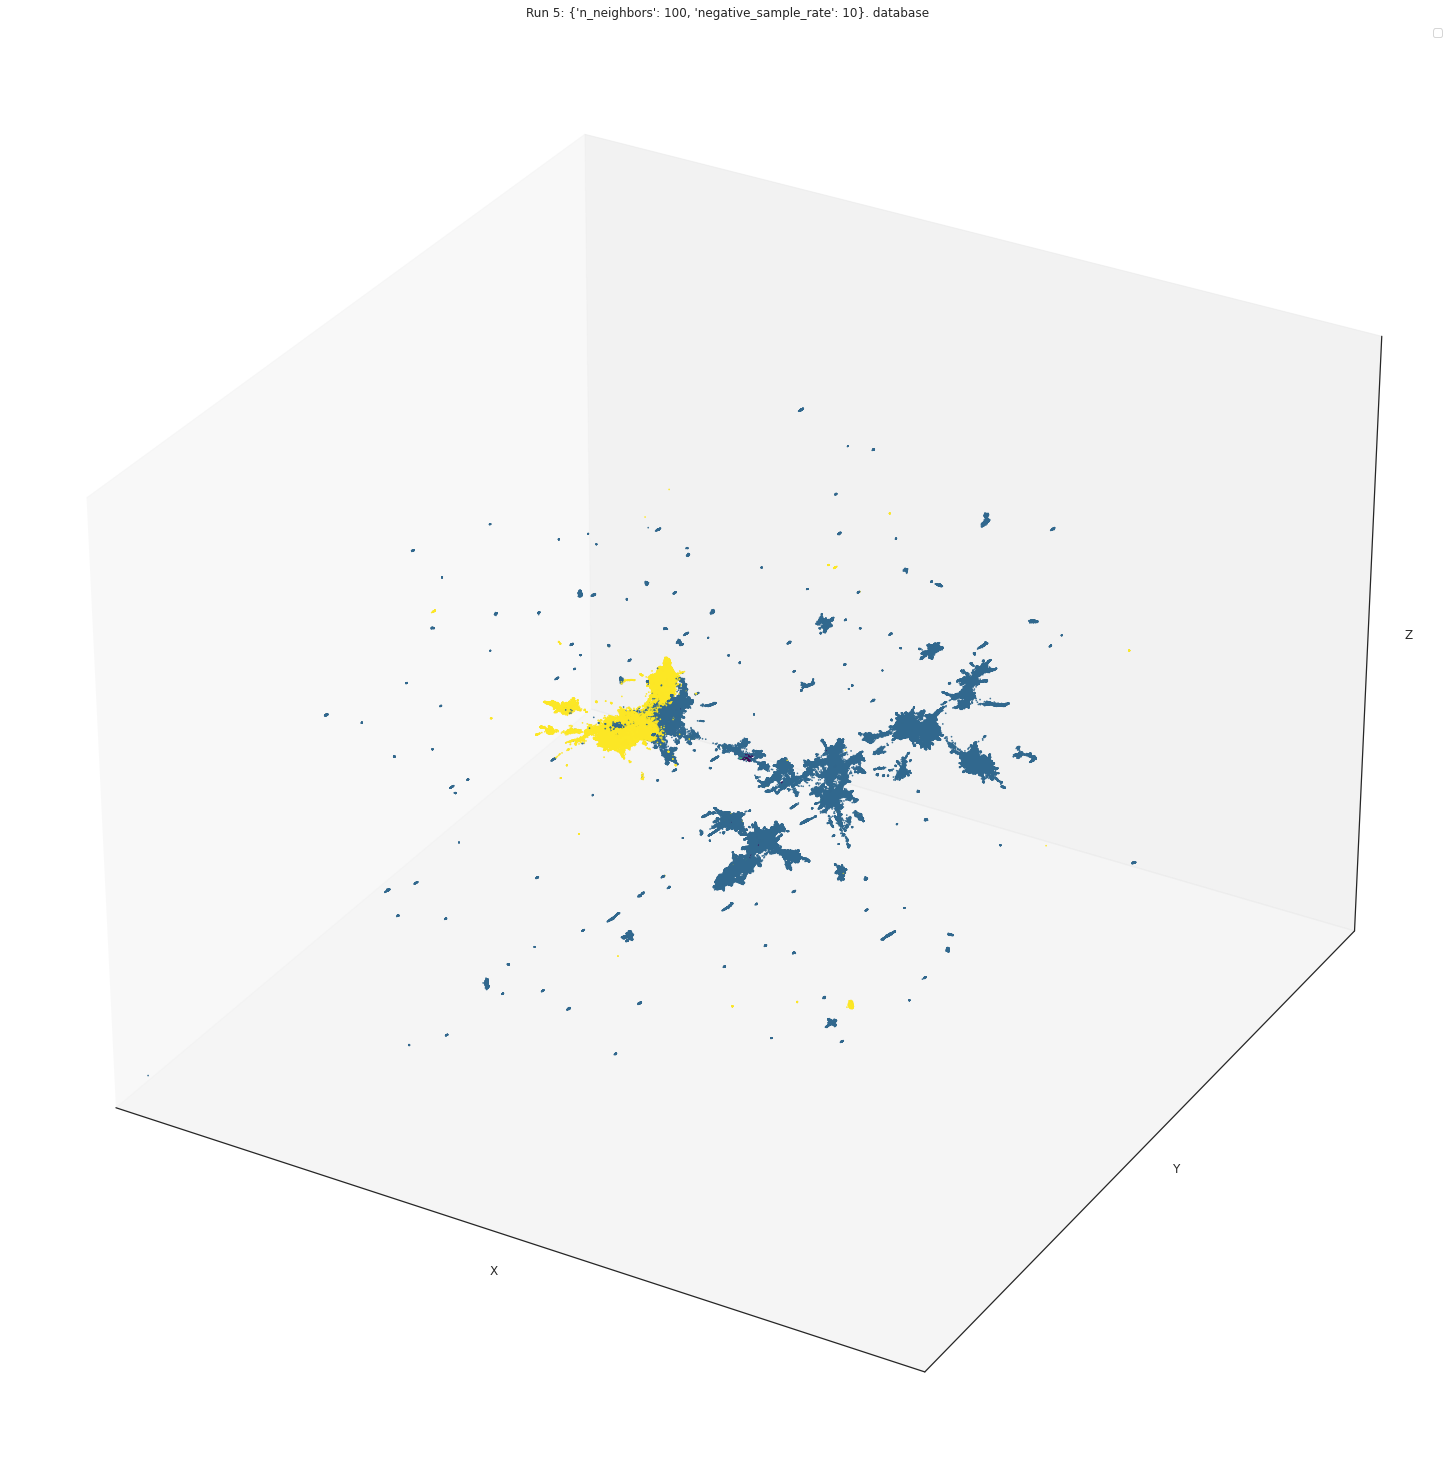

<Figure size 1800x900 with 0 Axes>

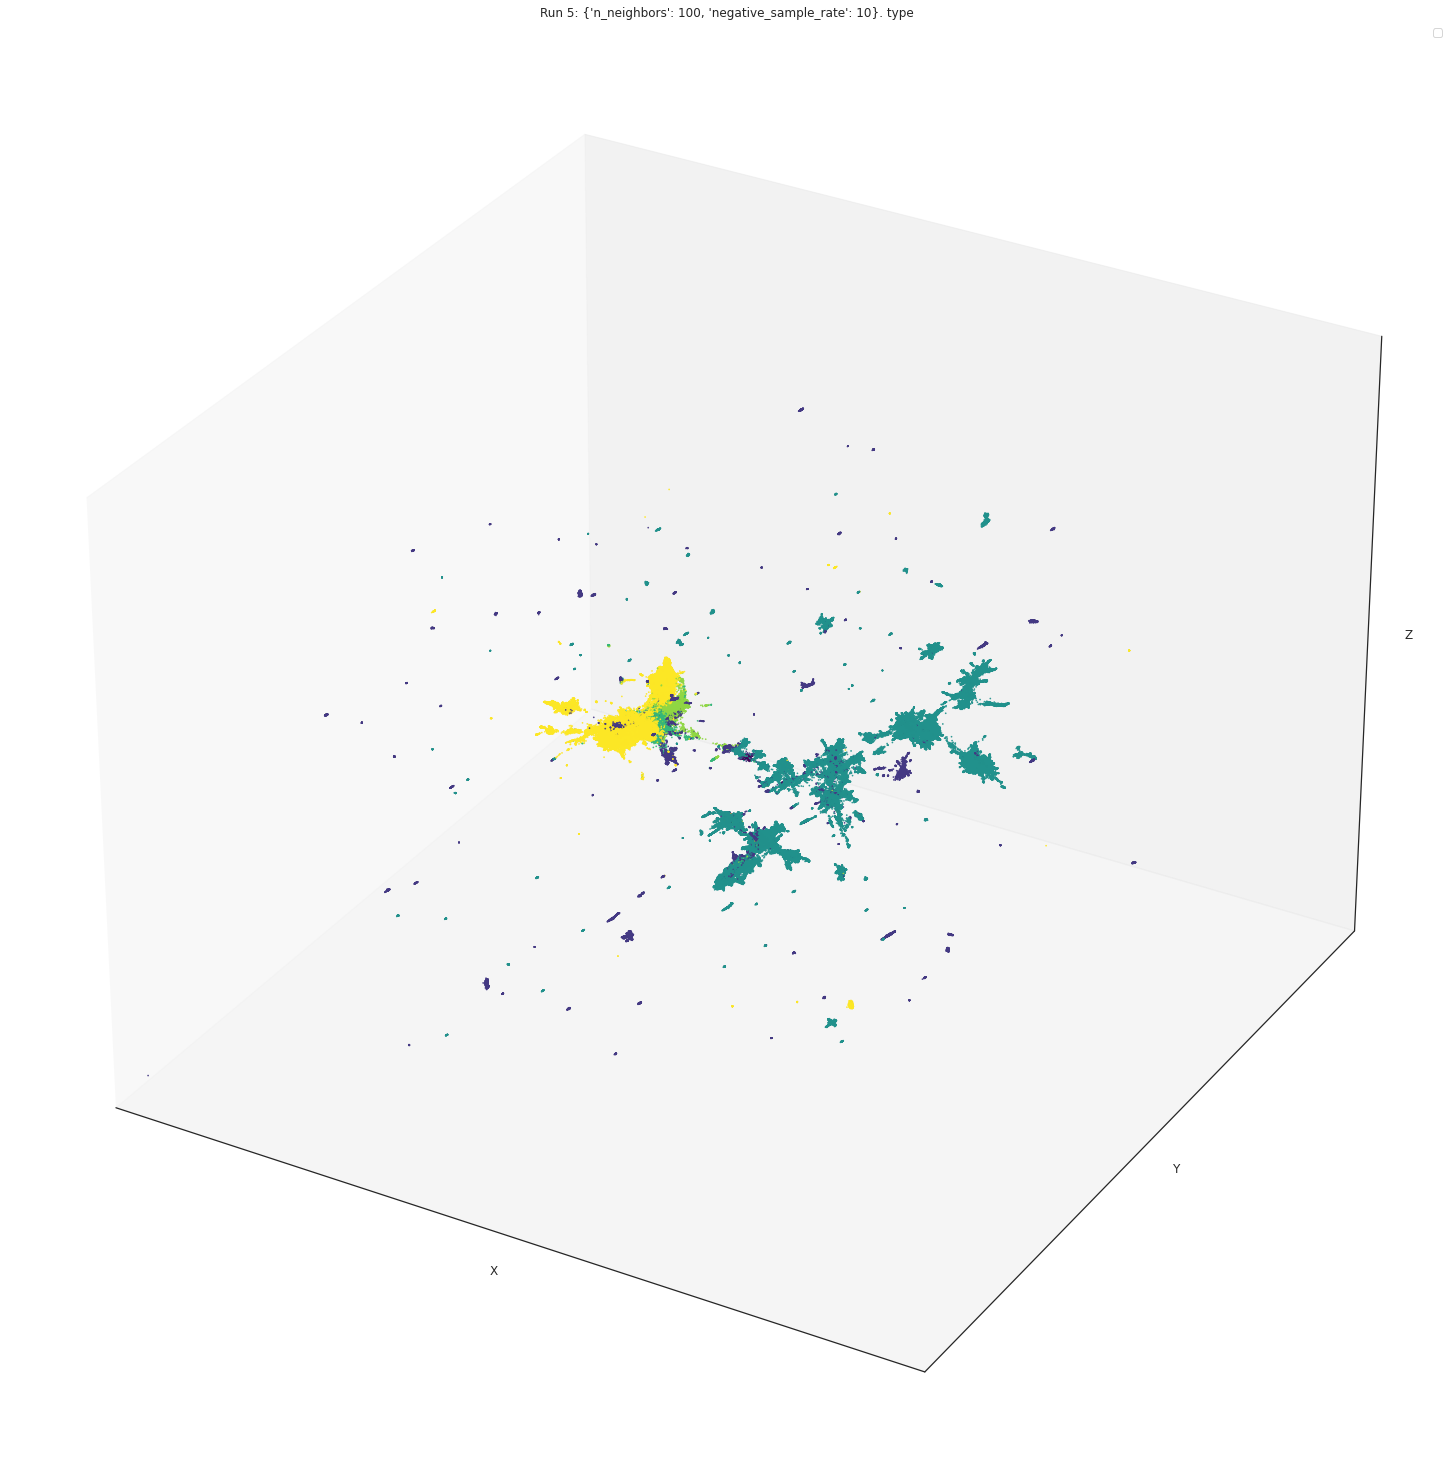

<Figure size 1800x900 with 0 Axes>

In [70]:
save_folder = "umap_parameter_tuning_3d"    
if not os.path.exists(save_folder): os.mkdir(save_folder)

for idx, p in tqdm(enumerate(param_list)):
    projection = run_iteration(p, idx+1)


## Train final model and save embeddings

In [72]:
best_projection_save_path = "../data/processed/final_model_dglke/best_projection_3d.npy"
best_model_params = {
    "n_neighbors": 100,
    "negative_sample_rate": 10,
}

projection_best = UMAP(    
    **best_model_params,
    n_epochs=1000,
    n_components=3,
).fit_transform(ent_embeddings)

In [73]:
with open(best_projection_save_path, "wb") as f: 
    np.save(f, projection_best)